In [ ]:
from google.colab import drive
drive.mount('/content/drive')

!mkdir -p ~/.kaggle
!cp /content/drive/MyDrive/kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle competitions download -c playground-series-s4e12
!unzip /content/playground-series-s4e12.zip
!rm /content/playground-series-s4e12.zip

Mounted at /content/drive
100% 75.5M/75.5M [00:01<00:00, 70.7MB/s]
100% 75.5M/75.5M [00:01<00:00, 78.5MB/s]
Archive:  /content/playground-series-s4e12.zip
  inflating: sample_submission.csv   
  inflating: test.csv                
  inflating: train.csv               


In [ ]:
!pip install autogluon.tabular[all]

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 266.2/266.2 kB 14.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.1/64.1 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.2/68.2 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 88.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 352.2/352.2 kB 25.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.2/139.2 kB 11.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.3/66.3 MB 10.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 93.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 76.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.2/83.2 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.3/4.3

## Import Packages

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, GammaRegressor, Ridge
from sklearn.metrics import make_scorer, mean_squared_error
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
# from keras_tuner import HyperModel
# from keras_tuner import RandomSearch
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras import layers, models

from autogluon.tabular import TabularDataset, TabularPredictor
from scipy.stats import boxcox

## Load Data

In [ ]:
train = pd.read_csv('/content/train.csv', index_col = 0)
test = pd.read_csv('/content/test.csv', index_col = 0)
sub = pd.read_csv('/content/sample_submission.csv')

In [ ]:
sub.head()

id  Premium Amount
0  1200000        1102.545
1  1200001        1102.545
2  1200002        1102.545
3  1200003        1102.545
4  1200004        1102.545

### Adversarial CV

### Feature Engineer

In [ ]:
def create_age_bins(df, column='Age', bin_size=10):
    """
    Create bins for the specified age column in given intervals, leaving NaNs as NaNs.

    Parameters:
    df (pd.DataFrame): The DataFrame to process.
    column (str): The name of the column to bin.
    bin_size (int): The size of the bins (default is 10).

    Returns:
    pd.DataFrame: The DataFrame with an additional column '<column>_bins' containing the binned values.
    """
    # Define bin edges
    min_age = df[column].min(skipna=True) // bin_size * bin_size  # Round down to nearest bin_size
    max_age = (df[column].max(skipna=True) // bin_size + 1) * bin_size  # Round up to nearest bin_size
    bins = np.arange(min_age, max_age + bin_size, bin_size)

    # Define bin labels
    labels = [f'{int(bins[i])}-{int(bins[i + 1]) - 1}' for i in range(len(bins) - 1)]

    # Apply binning, preserving NaNs
    df[f'{column}_bins'] = pd.cut(df[column], bins=bins, labels=labels, include_lowest=True)

    return df


def process_policy_start_date(df, column='Policy Start Date'):
    """
    Process the Policy Start Date column by converting it to datetime, splitting into components,
    and dropping the original column.

    Parameters:
    df (pd.DataFrame): The DataFrame to process.
    column (str): The name of the column to process (default is 'Policy Start Date').

    Returns:
    pd.DataFrame: The DataFrame with added components and the original column removed.
    """
    # Convert to datetime
    df[column] = pd.to_datetime(df[column])

    # Extract components
    df[f'{column}_Year'] = df[column].dt.year
    df[f'{column}_Month'] = df[column].dt.month
    df[f'{column}_Day'] = df[column].dt.day
    # df[f'{column}_Hour'] = df[column].dt.hour
    # df[f'{column}_Minute'] = df[column].dt.minute
    # df[f'{column}_Second'] = df[column].dt.second


    # Drop the original column
    df.drop(columns=[column], inplace=True)

    return df

def apply_log_transform(df, columns, suffix='_log'):
    """
    Apply log transformation to a list of columns in a dataframe and create new columns,
    handling NaNs gracefully.

    Parameters:
    df (pd.DataFrame): The dataframe to process.
    columns (list): List of column names to transform.
    suffix (str): Suffix for the new column names.

    Returns:
    pd.DataFrame: The dataframe with new log-transformed columns.
    """
    for col in columns:
        new_col_name = f"{col}{suffix}"
        # Apply log transform while skipping NaNs
        df[new_col_name] = np.log(df[col] + 1).where(df[col].notna(), np.nan)
    return df

def apply_boxcox_transform(df, columns, suffix='_boxcox'):
    """
    Apply Box-Cox transformation to a list of columns in a dataframe and create new columns,
    handling NaNs and errors gracefully.

    Parameters:
    df (pd.DataFrame): The dataframe to process.
    columns (list): List of column names to transform.
    suffix (str): Suffix for the new column names.

    Returns:
    pd.DataFrame: The dataframe with new Box-Cox-transformed columns.
    """
    for col in columns:
        new_col_name = f"{col}{suffix}"
        try:
            # Ensure all values are positive for Box-Cox
            if (df[col] <= 0).any(skipna=True):
                raise ValueError(f"Column '{col}' contains non-positive values, which are not allowed for Box-Cox.")

            # Apply Box-Cox transformation while skipping NaNs
            df[new_col_name] = df[col].apply(lambda x: boxcox(x)[0] if pd.notna(x) else np.nan)
        except Exception as e:
            print(f"Error processing column '{col}': {e}")

    return df

In [ ]:
numeric_cols = [
    # 'Age',
 'Annual Income',
 'Number of Dependents',
 'Health Score',
 'Previous Claims',
 'Vehicle Age',
 'Credit Score',
 'Insurance Duration']

# Apply the function to both train and test DataFrames
train = create_age_bins(train, column='Age', bin_size=10)
test = create_age_bins(test, column='Age', bin_size=10)

# Process the Policy Start Date column for both train and test DataFrames
train = process_policy_start_date(train, column='Policy Start Date')
test = process_policy_start_date(test, column='Policy Start Date')

# Apply log transformation
train = apply_log_transform(train, numeric_cols)
test = apply_log_transform(test, numeric_cols)

# Apply Box-Cox transformation
train = apply_boxcox_transform(train, numeric_cols)
test = apply_boxcox_transform(test, numeric_cols)

train['Customer Feedback'] = train['Customer Feedback'].fillna('Missing')
train['Marital Status'] = train['Marital Status'].fillna('Missing')

test['Customer Feedback'] = test['Customer Feedback'].fillna('Missing')
test['Marital Status'] = test['Marital Status'].fillna('Missing')

Error processing column 'Annual Income': Data must be 1-dimensional.
Error processing column 'Number of Dependents': Column 'Number of Dependents' contains non-positive values, which are not allowed for Box-Cox.
Error processing column 'Health Score': Data must be 1-dimensional.
Error processing column 'Previous Claims': Column 'Previous Claims' contains non-positive values, which are not allowed for Box-Cox.
Error processing column 'Vehicle Age': Column 'Vehicle Age' contains non-positive values, which are not allowed for Box-Cox.
Error processing column 'Credit Score': Data must be 1-dimensional.
Error processing column 'Insurance Duration': Data must be 1-dimensional.
Error processing column 'Annual Income': Data must be 1-dimensional.
Error processing column 'Number of Dependents': Column 'Number of Dependents' contains non-positive values, which are not allowed for Box-Cox.
Error processing column 'Health Score': Data must be 1-dimensional.
Error processing column 'Previous Claims

In [ ]:
bin_edges = list(range(0, int(train['Premium Amount'].max()) + 1000, 1000))
bin_labels = [f"{bin_edges[i]}-{bin_edges[i+1]}" for i in range(len(bin_edges) - 1)]

# Add the new column with binned data
train['Premium Bins'] = pd.cut(
    train['Premium Amount'],
    bins=bin_edges,
    labels=bin_labels,
    include_lowest=True,
    right=False
)

In [ ]:
train['Premium Bins'].value_counts()

Premium Bins
0-1000       679099
1000-2000    331855
2000-3000    139688
3000-4000     41420
4000-5000      7938
Name: count, dtype: int64

## EDA

In [ ]:
target = 'Premium Amount'

In [ ]:
train[target].describe()

count    1.200000e+06
mean     1.102545e+03
std      8.649989e+02
min      2.000000e+01
25%      5.140000e+02
50%      8.720000e+02
75%      1.509000e+03
max      4.999000e+03
Name: Premium Amount, dtype: float64

<Axes: >

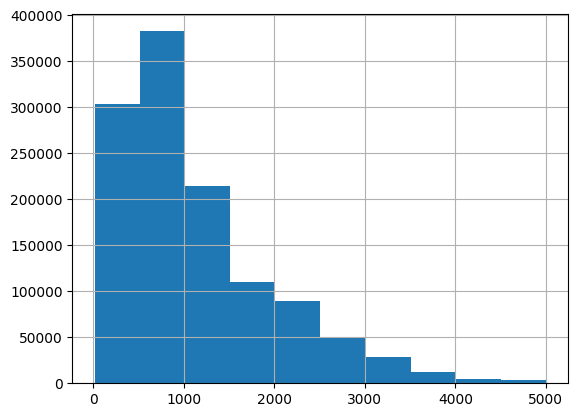

In [ ]:
train[target].hist()

In [ ]:
train.groupby('Premium Bins')[target].describe()

<ipython-input-13-87aef37eb937>:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  train.groupby('Premium Bins')[target].describe()


count         mean         std     min     25%     50%  \
Premium Bins                                                              
0-1000        679099.0   515.793777  287.886669    20.0   270.0   553.0   
1000-2000     331855.0  1388.523596  263.313534  1000.0  1164.0  1347.0   
2000-3000     139688.0  2409.047098  278.581967  2000.0  2149.0  2370.0   
3000-4000      41420.0  3384.276437  273.193377  3000.0  3149.0  3326.0   
4000-5000       7938.0  4446.781179  325.667513  4000.0  4108.0  4415.0   

                 75%     max  
Premium Bins                  
0-1000         743.0   999.0  
1000-2000     1601.0  1999.0  
2000-3000     2627.0  2999.0  
3000-4000     3568.0  3999.0  
4000-5000     4786.0  4999.0

In [ ]:
train.isna().sum()

Age                          18705
Gender                           0
Annual Income                44949
Marital Status               18529
Number of Dependents        109672
Education Level                  0
Occupation                  358075
Health Score                 74076
Location                         0
Policy Type                      0
Previous Claims             364029
Vehicle Age                      6
Credit Score                137882
Insurance Duration               1
Customer Feedback            77824
Smoking Status                   0
Exercise Frequency               0
Property Type                    0
Premium Amount                   0
Age_bins                     18705
Policy Start Date_Year           0
Policy Start Date_Month          0
Policy Start Date_Day            0
Policy Start Date_Hour           0
Policy Start Date_Minute         0
Policy Start Date_Second         0
Annual Income_log            44949
Number of Dependents_log    109672
Health Score_log             74076
Previous Claims_log         364029
Vehicle Age_log                  6
Credit Score_log            137882
Insurance Duration_log           1
dtype: int64

In [ ]:
test.isna().sum()

Age                      12489
Gender                       0
Annual Income            29860
Marital Status           12336
Number of Dependents     73130
Education Level              0
Occupation              239125
Health Score             49449
Location                     0
Policy Type                  0
Previous Claims         242802
Vehicle Age                  3
Credit Score             91451
Insurance Duration           2
Policy Start Date            0
Customer Feedback        52276
Smoking Status               0
Exercise Frequency           0
Property Type                0
dtype: int64

In [ ]:
train.columns

Index(['Age', 'Gender', 'Annual Income', 'Marital Status',
       'Number of Dependents', 'Education Level', 'Occupation', 'Health Score',
       'Location', 'Policy Type', 'Previous Claims', 'Vehicle Age',
       'Credit Score', 'Insurance Duration', 'Policy Start Date',
       'Customer Feedback', 'Smoking Status', 'Exercise Frequency',
       'Property Type', 'Premium Amount'],
      dtype='object')

In [ ]:
test.columns

Index(['Age', 'Gender', 'Annual Income', 'Marital Status',
       'Number of Dependents', 'Education Level', 'Occupation', 'Health Score',
       'Location', 'Policy Type', 'Previous Claims', 'Vehicle Age',
       'Credit Score', 'Insurance Duration', 'Policy Start Date',
       'Customer Feedback', 'Smoking Status', 'Exercise Frequency',
       'Property Type'],
      dtype='object')

In [ ]:
numeric_cols = ['Age',
 'Annual Income',
 'Number of Dependents',
 'Health Score',
 'Previous Claims',
 'Vehicle Age',
 'Credit Score',
 'Insurance Duration']
cat_cols = ['Gender',
 'Marital Status',
 'Education Level',
 'Occupation',
 'Location',
 'Policy Type',
#  'Policy Start Date',
 'Customer Feedback',
 'Smoking Status',
 'Exercise Frequency',
 'Property Type']

In [ ]:
train[numeric_cols + [target]].corr().style.background_gradient(cmap = 'coolwarm', vmin = -1, vmax = 1)

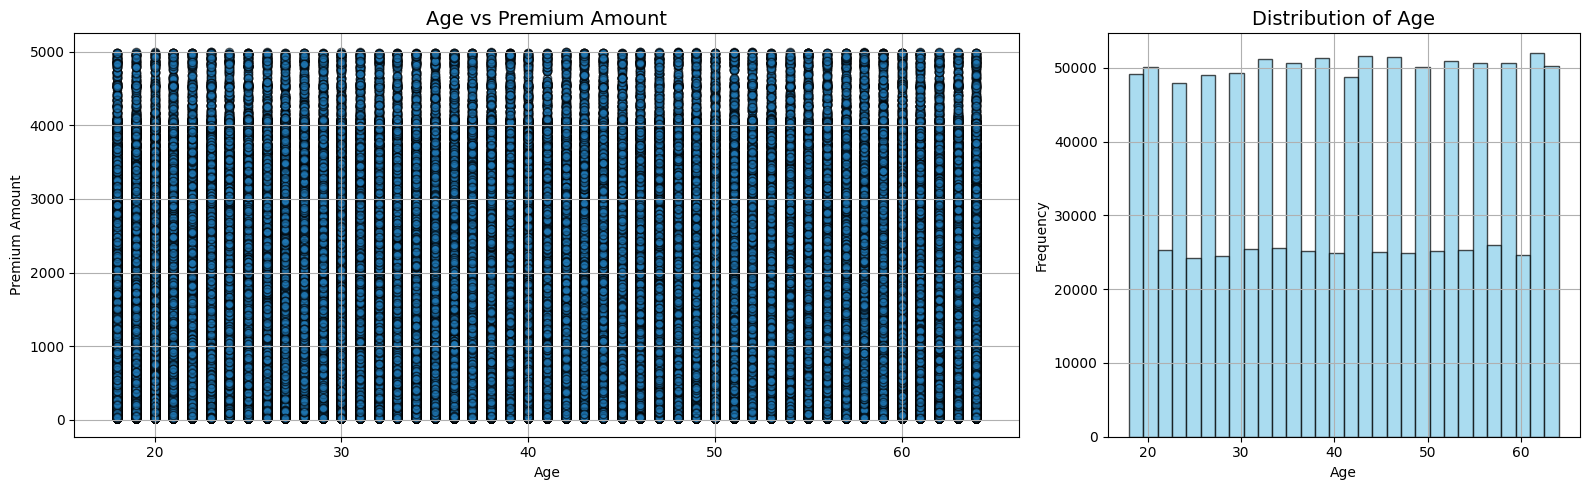

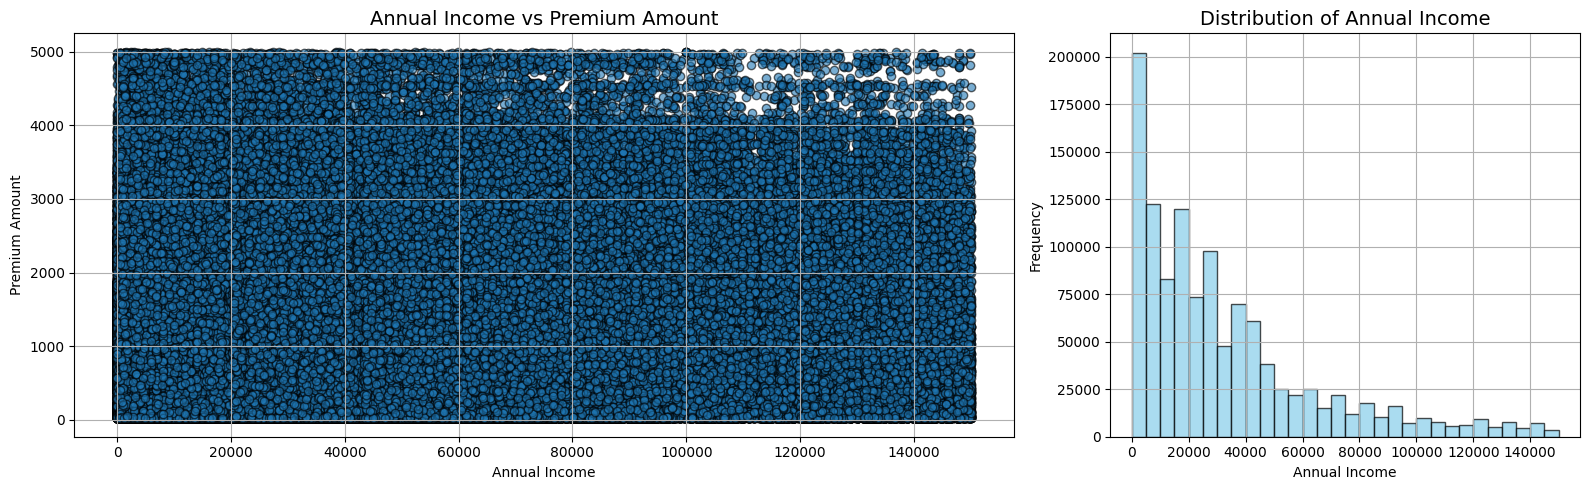

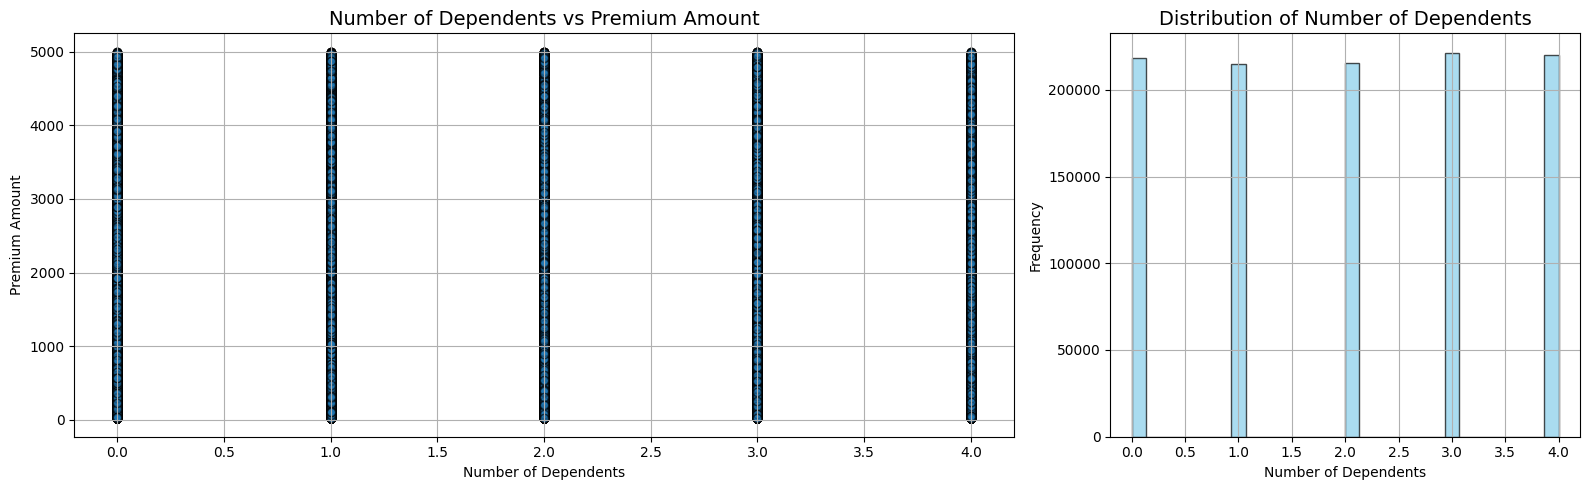

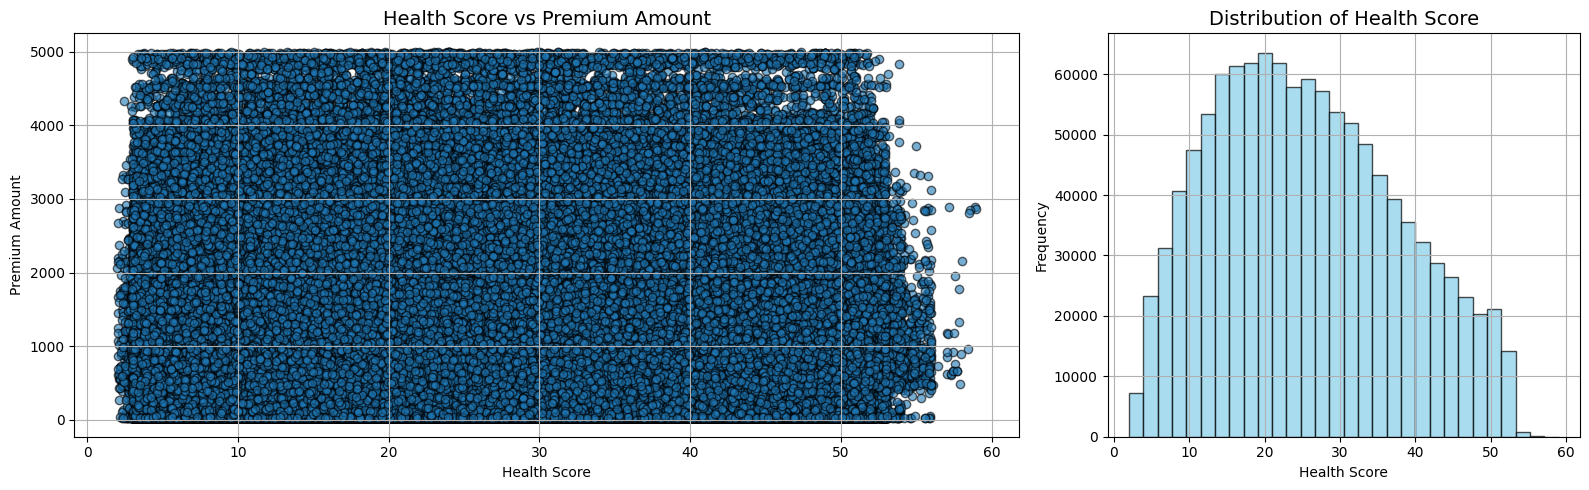

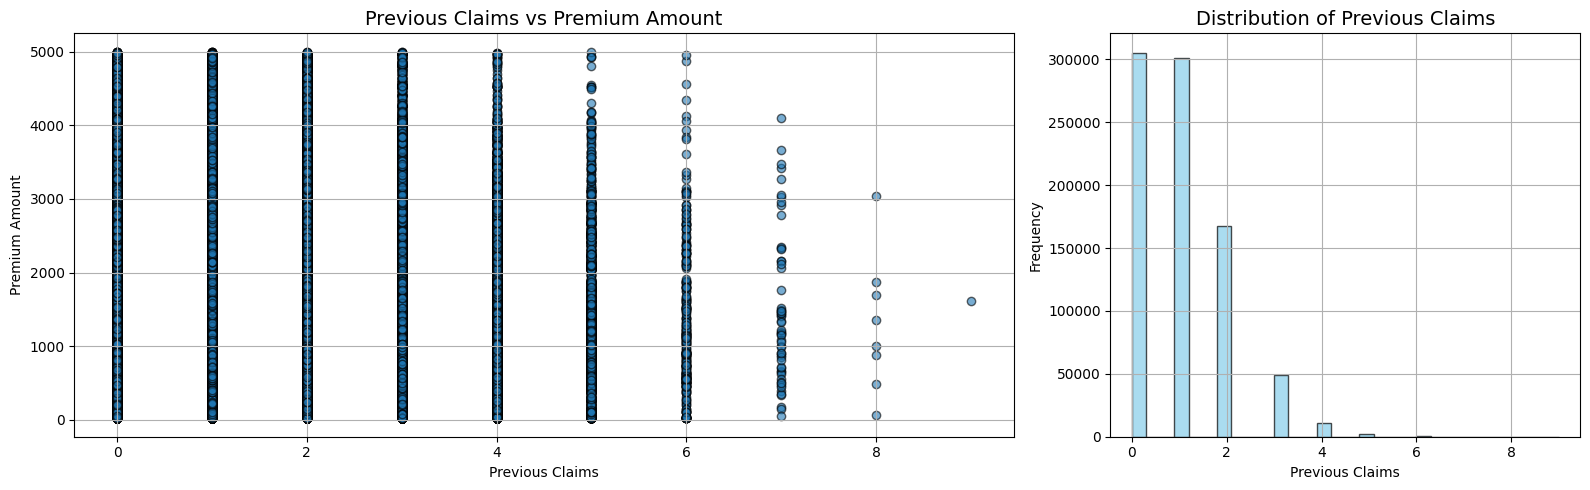

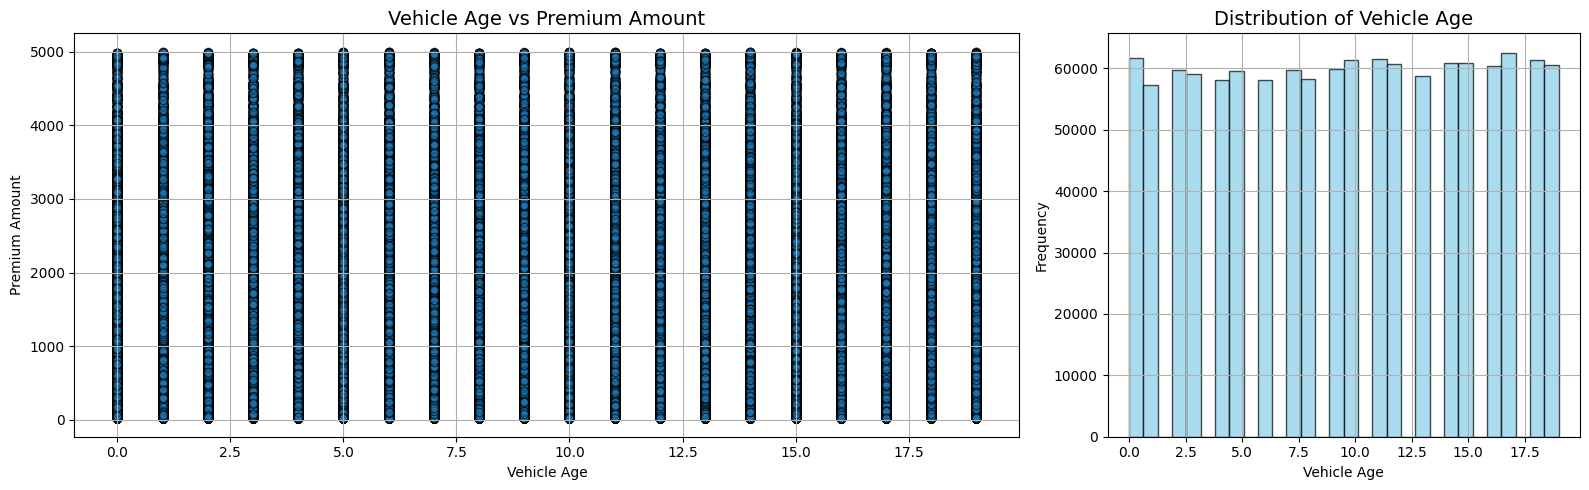

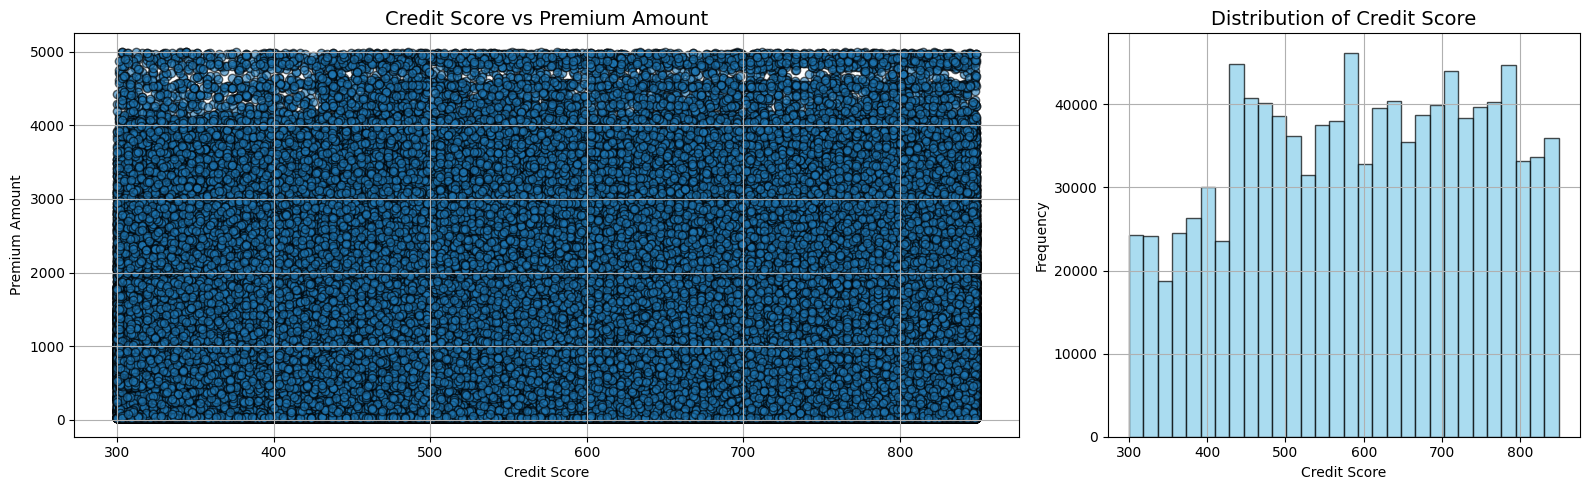

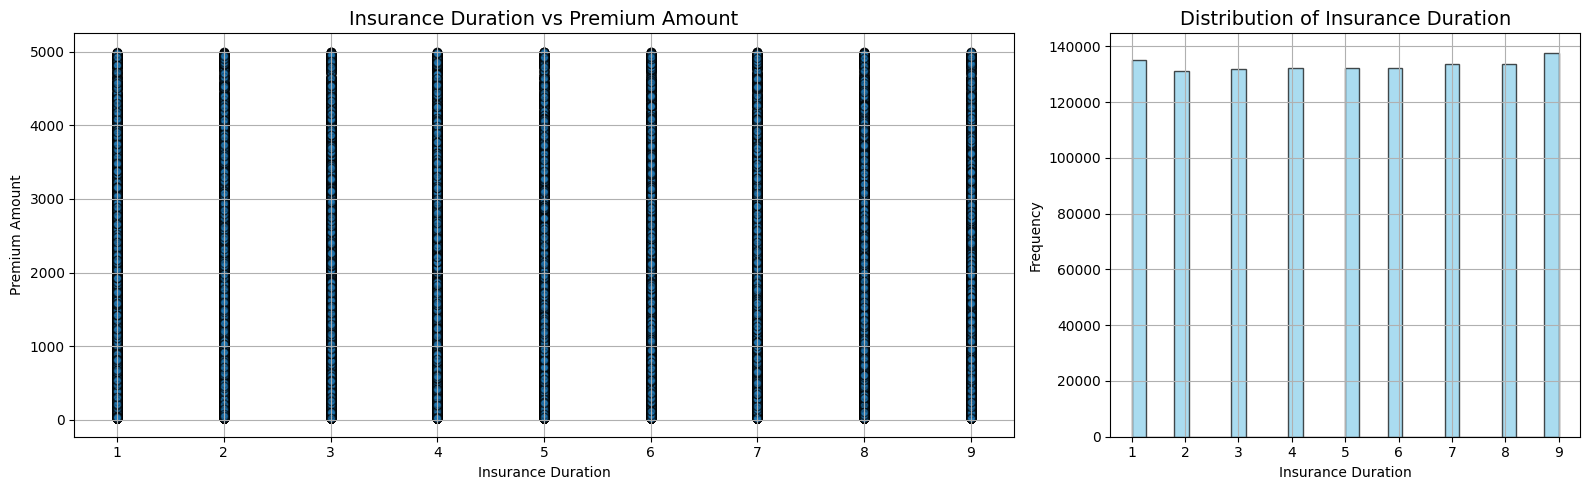

In [ ]:
for col in numeric_cols:
    fig, axes = plt.subplots(1, 2, figsize=(16, 5), gridspec_kw={'width_ratios': [2, 1]})

    # Scatterplot: Numeric column vs Premium Amount
    axes[0].scatter(train[col], train['Premium Amount'], alpha=0.6, edgecolor='k')
    axes[0].set_title(f'{col} vs Premium Amount', fontsize=14)
    axes[0].set_xlabel(col)
    axes[0].set_ylabel('Premium Amount')
    axes[0].grid(True)

    # Histogram: Distribution of the numeric column
    axes[1].hist(train[col], bins=30, color='skyblue', edgecolor='k', alpha=0.7)
    axes[1].set_title(f'Distribution of {col}', fontsize=14)
    axes[1].set_xlabel(col)
    axes[1].set_ylabel('Frequency')
    axes[1].grid(True)

    plt.tight_layout()
    plt.show()

<ipython-input-41-78514bcc3b65>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=train[f'{col}_with_missing'], y=train['Premium Amount'], palette="Set2")


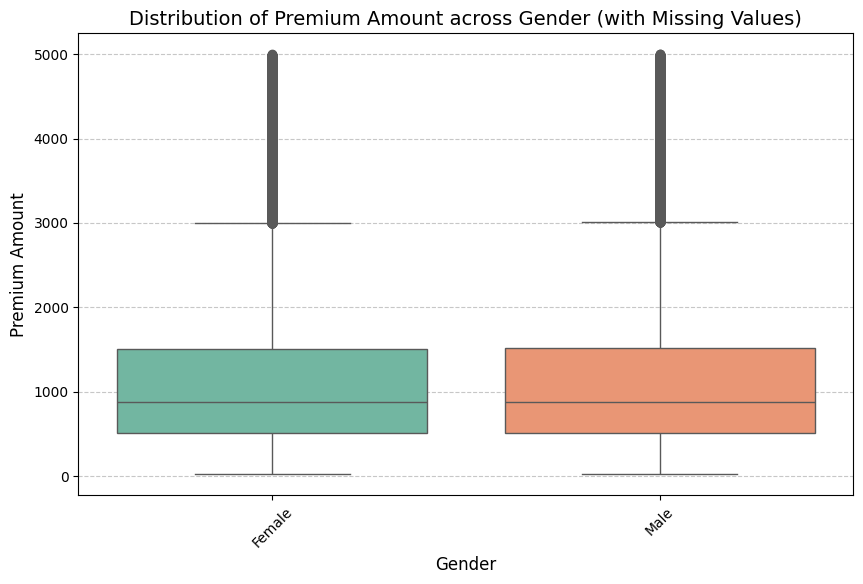

<ipython-input-41-78514bcc3b65>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=train[f'{col}_with_missing'], y=train['Premium Amount'], palette="Set2")


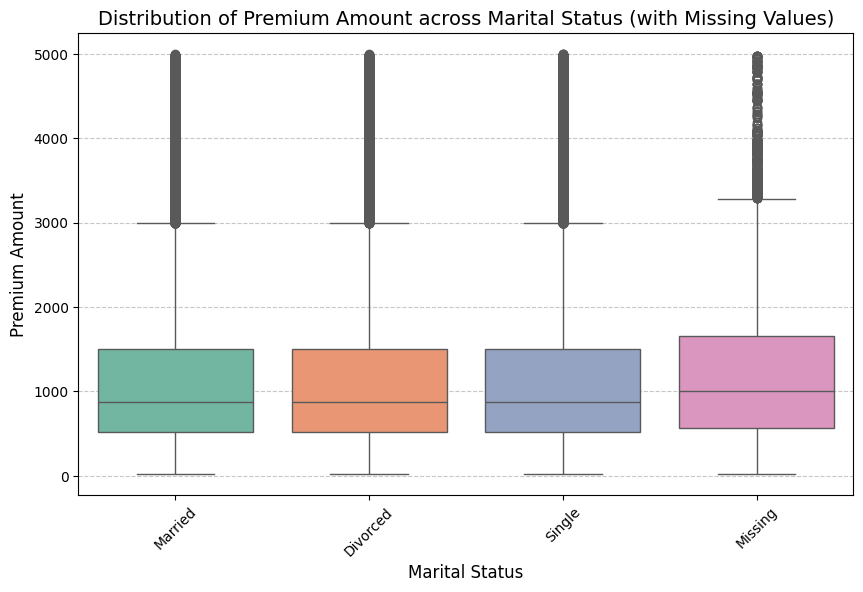

<ipython-input-41-78514bcc3b65>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=train[f'{col}_with_missing'], y=train['Premium Amount'], palette="Set2")


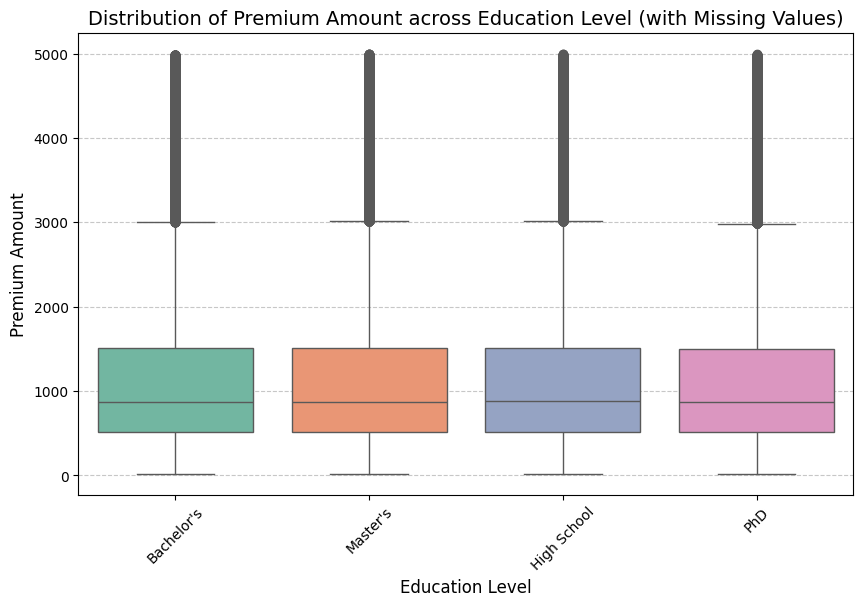

<ipython-input-41-78514bcc3b65>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=train[f'{col}_with_missing'], y=train['Premium Amount'], palette="Set2")


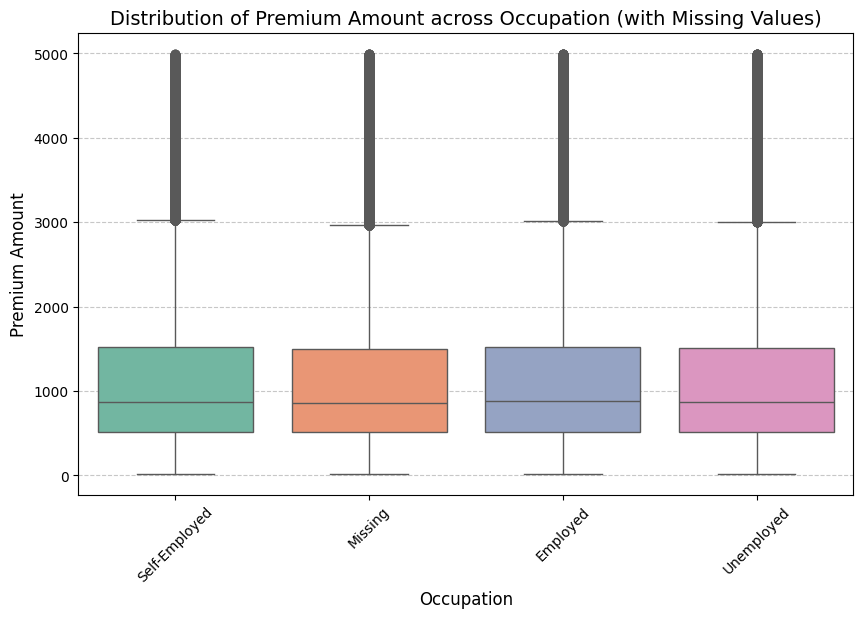

<ipython-input-41-78514bcc3b65>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=train[f'{col}_with_missing'], y=train['Premium Amount'], palette="Set2")


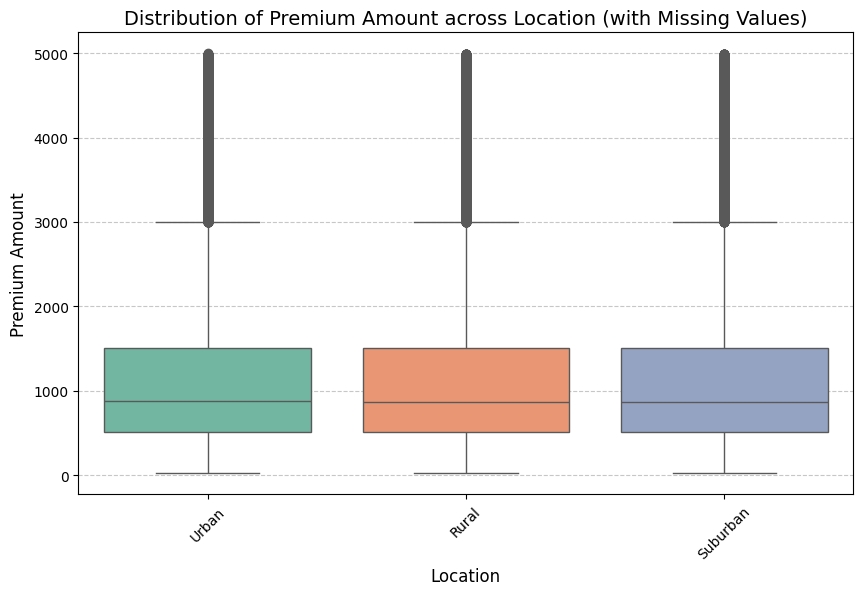

<ipython-input-41-78514bcc3b65>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=train[f'{col}_with_missing'], y=train['Premium Amount'], palette="Set2")


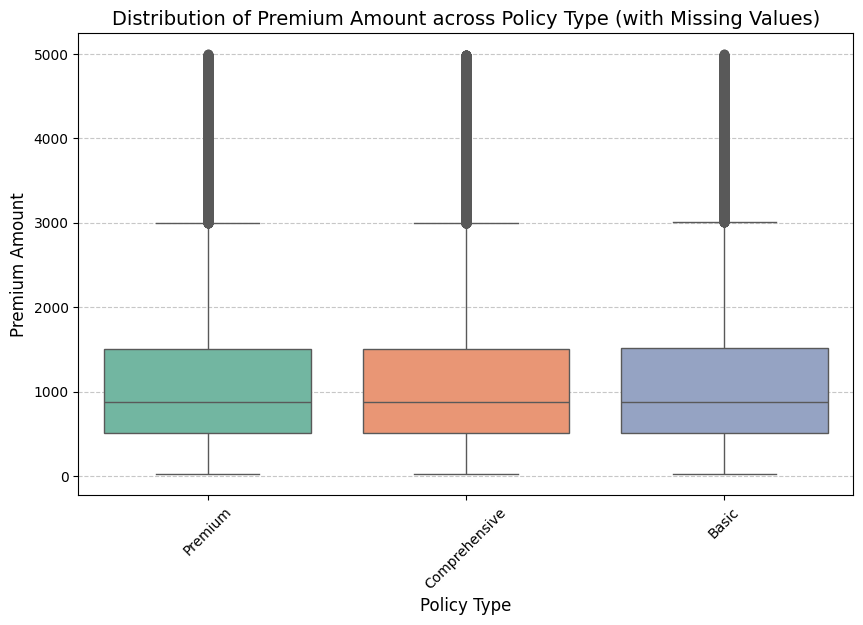

<ipython-input-41-78514bcc3b65>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=train[f'{col}_with_missing'], y=train['Premium Amount'], palette="Set2")


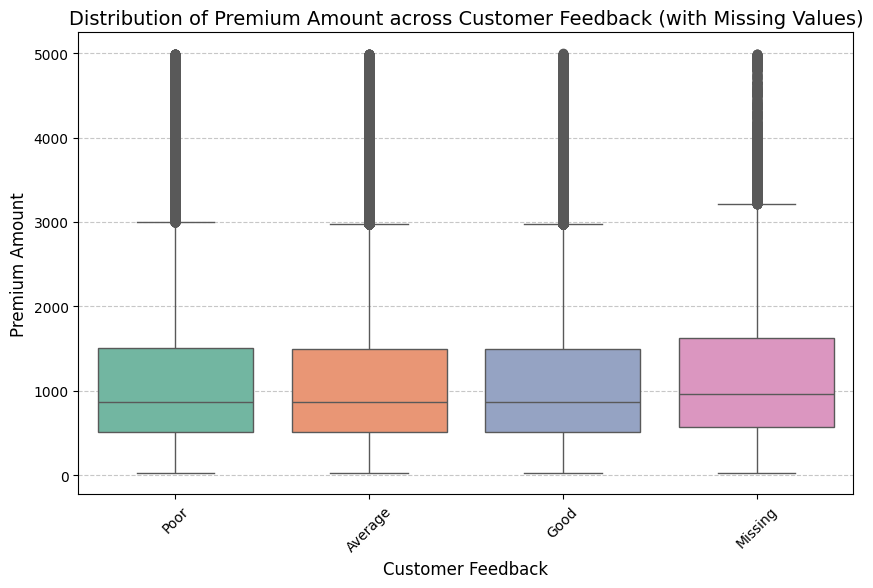

<ipython-input-41-78514bcc3b65>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=train[f'{col}_with_missing'], y=train['Premium Amount'], palette="Set2")


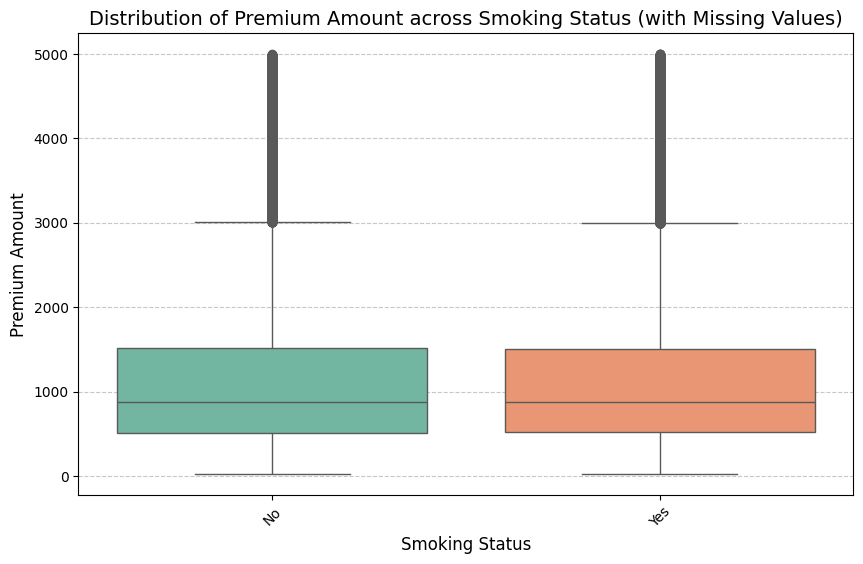

<ipython-input-41-78514bcc3b65>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=train[f'{col}_with_missing'], y=train['Premium Amount'], palette="Set2")


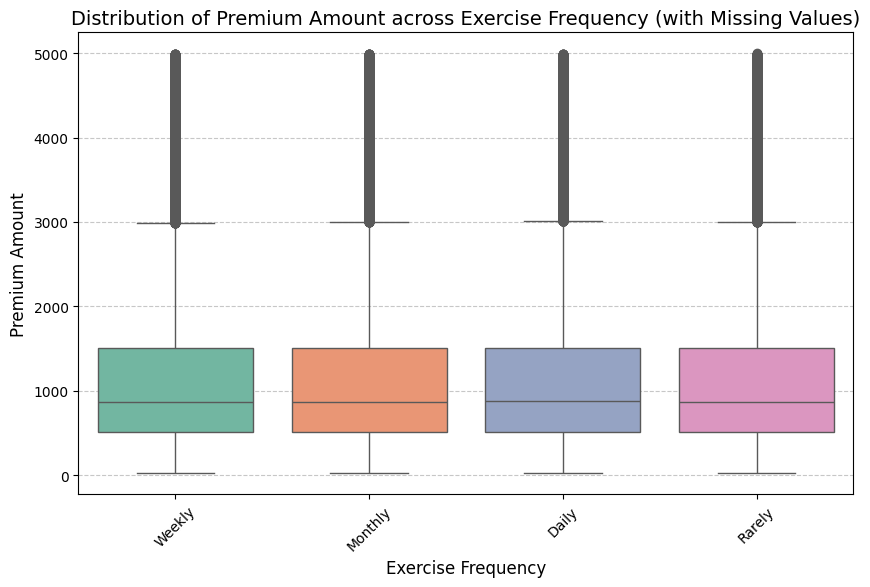

<ipython-input-41-78514bcc3b65>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=train[f'{col}_with_missing'], y=train['Premium Amount'], palette="Set2")


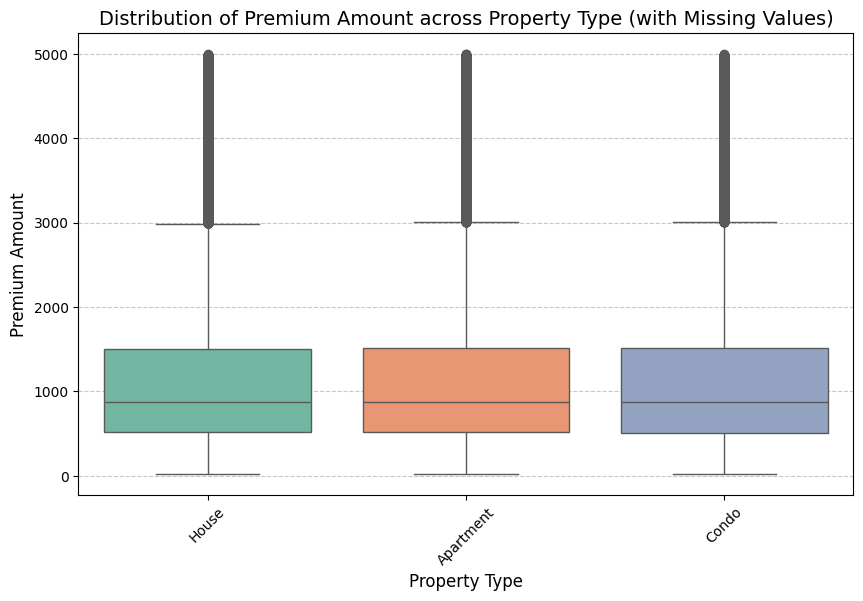

In [ ]:
for col in cat_cols:
    # Create a new column where NaN values are replaced with the string "Missing"
    train[f'{col}_with_missing'] = train[col].fillna('Missing')

    # Plot boxplot for the categorical column with missing values as a separate category
    plt.figure(figsize=(10, 6))
    sns.boxplot(x=train[f'{col}_with_missing'], y=train['Premium Amount'], palette="Set2")
    plt.title(f'Distribution of Premium Amount across {col} (with Missing Values)', fontsize=14)
    plt.xlabel(col, fontsize=12)
    plt.ylabel('Premium Amount', fontsize=12)
    plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

    # Optionally, drop the temporary column after plotting
    train.drop(columns=[f'{col}_with_missing'], inplace=True)

In [ ]:
train['Age'].describe()

count    1.181295e+06
mean     4.114556e+01
std      1.353995e+01
min      1.800000e+01
25%      3.000000e+01
50%      4.100000e+01
75%      5.300000e+01
max      6.400000e+01
Name: Age, dtype: float64

In [ ]:
train['Policy Start Date']

id
0          2023-12-23 15:21:39.134960
1          2023-06-12 15:21:39.111551
2          2023-09-30 15:21:39.221386
3          2024-06-12 15:21:39.226954
4          2021-12-01 15:21:39.252145
                      ...            
1199995    2023-05-03 15:21:39.257696
1199996    2022-09-10 15:21:39.134960
1199997    2021-05-25 15:21:39.106582
1199998    2021-09-19 15:21:39.190215
1199999    2020-08-26 15:21:39.155231
Name: Policy Start Date, Length: 1200000, dtype: object

## AutoML Model
1. Base Score: 1.13913
2. Feat engineer: WeightedEnsemble_L3	-839.502822 (Score: 1.13692)
3. Updated error metric:  LightGBMXT_BAG_L1	-1.138586	(Score: 1.13564)
4. Different time feats: LightGBMXT_BAG_L1	-1.139439 (Score: 1.13662)
5. reset : LightGBMXT_BAG_L1 (Score: -1.138869)
6. np.transform: LightGBMXT_BAG_L1 -0.158938 (Score: 1.04944)

In [ ]:
train[label] = np.log1p(train[label])

In [ ]:
label = 'Premium Amount'#'Premium Bins' #'Premium Amount'
metric = "root_mean_squared_error"#'balanced_accuracy'#"root_mean_squared_error"
time_limit = 600

excluded_model_types = ['KNN']

In [ ]:
# New metric
from sklearn.metrics import root_mean_squared_log_error
from autogluon.core.metrics import make_scorer

ag_mean_squared_error_scorer = make_scorer(name='root_mean_squared_log_error',
                                           score_func=root_mean_squared_log_error,
                                           optimum=0,
                                           greater_is_better=False)

In [ ]:
# # Initialize lists to store dropped columns and scores
# drop_cols = []
# score = []

# # Iterate through columns in the test dataset
# for i in test.columns:
#     print(f"Processing column: {i}")  # Log progress for long operations
#     # Fit the TabularPredictor after dropping the current column
#     predictor = TabularPredictor(label, eval_metric=ag_mean_squared_error_scorer).fit(
#         train.drop(i, axis=1),
#         auto_stack=True,
#         excluded_model_types=excluded_model_types,
#         time_limit=60,
#         presets='best_quality'
#     )
#     # Append the validation score and the column name
#     score.append(predictor.leaderboard(silent=True)['score_val'][0])
#     drop_cols.append(i)

# # Create a DataFrame from the results
# results_df = pd.DataFrame({
#     'dropped_column': drop_cols,
#     'validation_score': score
# })

# # Save the DataFrame to a CSV file
# results_df.to_csv('/content/drive/MyDrive/Output/dropped_columns_scores.csv', index=False)

# print("Results saved to '/content/drive/MyDrive/Output/dropped_columns_scores.csv'.")

No path specified. Models will be saved in: "AutogluonModels/ag-20241220_190748"


Processing column: Age


Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.10.12
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Thu Jun 27 21:05:47 UTC 2024
CPU Count:          2
Memory Avail:       8.56 GB / 12.67 GB (67.5%)
Disk Space Avail:   73.64 GB / 107.72 GB (68.4%)
Presets specified: ['best_quality']
Setting dynamic_stacking from 'auto' to True. Reason: Enable dynamic_stacking when use_bag_holdout is disabled. (use_bag_holdout=False)
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=1
DyStack is enabled (dynamic_stacking=True). AutoGluon will try to determine whether the input data is affected by stacked overfitting and enable or disable stacking as a consequence.
	This is used to identify the optimal `num_stack_levels` value. Copies of AutoGluon will be fit on subsets of the data. Then holdout validation data is used to detect stacked 

Processing column: Gender


Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.10.12
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Thu Jun 27 21:05:47 UTC 2024
CPU Count:          2
Memory Avail:       7.96 GB / 12.67 GB (62.8%)
Disk Space Avail:   73.44 GB / 107.72 GB (68.2%)
Presets specified: ['best_quality']
Setting dynamic_stacking from 'auto' to True. Reason: Enable dynamic_stacking when use_bag_holdout is disabled. (use_bag_holdout=False)
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=1
DyStack is enabled (dynamic_stacking=True). AutoGluon will try to determine whether the input data is affected by stacked overfitting and enable or disable stacking as a consequence.
	This is used to identify the optimal `num_stack_levels` value. Copies of AutoGluon will be fit on subsets of the data. Then holdout validation data is used to detect stacked 

Processing column: Annual Income


Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.10.12
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Thu Jun 27 21:05:47 UTC 2024
CPU Count:          2
Memory Avail:       7.96 GB / 12.67 GB (62.8%)
Disk Space Avail:   73.22 GB / 107.72 GB (68.0%)
Presets specified: ['best_quality']
Setting dynamic_stacking from 'auto' to True. Reason: Enable dynamic_stacking when use_bag_holdout is disabled. (use_bag_holdout=False)
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=1
DyStack is enabled (dynamic_stacking=True). AutoGluon will try to determine whether the input data is affected by stacked overfitting and enable or disable stacking as a consequence.
	This is used to identify the optimal `num_stack_levels` value. Copies of AutoGluon will be fit on subsets of the data. Then holdout validation data is used to detect stacked 

Processing column: Marital Status


Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=1
DyStack is enabled (dynamic_stacking=True). AutoGluon will try to determine whether the input data is affected by stacked overfitting and enable or disable stacking as a consequence.
	This is used to identify the optimal `num_stack_levels` value. Copies of AutoGluon will be fit on subsets of the data. Then holdout validation data is used to detect stacked overfitting.
	Running DyStack for up to 15s of the 60s of remaining time (25%).
		Context path: "/content/AutogluonModels/ag-20241220_191245/ds_sub_fit/sub_fit_ho"
	No models were trained successfully during fit(). Inspect the log output or increase verbosity to determine why no models were fit. Alternatively, set `raise_on_no_models_fitted` to False during the fit call.
	1	 = Optimal   num_stack_levels (Stacked Overfitting Occurred: False)
	20s	 = DyStack   runtime |	40s	 = Remaining runtime
Starting main fit with num_stack_levels=1.
	For futur

Processing column: Number of Dependents


Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.10.12
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Thu Jun 27 21:05:47 UTC 2024
CPU Count:          2
Memory Avail:       8.00 GB / 12.67 GB (63.1%)
Disk Space Avail:   72.79 GB / 107.72 GB (67.6%)
Presets specified: ['best_quality']
Setting dynamic_stacking from 'auto' to True. Reason: Enable dynamic_stacking when use_bag_holdout is disabled. (use_bag_holdout=False)
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=1
DyStack is enabled (dynamic_stacking=True). AutoGluon will try to determine whether the input data is affected by stacked overfitting and enable or disable stacking as a consequence.
	This is used to identify the optimal `num_stack_levels` value. Copies of AutoGluon will be fit on subsets of the data. Then holdout validation data is used to detect stacked 

Processing column: Education Level


Setting dynamic_stacking from 'auto' to True. Reason: Enable dynamic_stacking when use_bag_holdout is disabled. (use_bag_holdout=False)
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=1
DyStack is enabled (dynamic_stacking=True). AutoGluon will try to determine whether the input data is affected by stacked overfitting and enable or disable stacking as a consequence.
	This is used to identify the optimal `num_stack_levels` value. Copies of AutoGluon will be fit on subsets of the data. Then holdout validation data is used to detect stacked overfitting.
	Running DyStack for up to 15s of the 60s of remaining time (25%).
		Context path: "/content/AutogluonModels/ag-20241220_191611/ds_sub_fit/sub_fit_ho"
	No models were trained successfully during fit(). Inspect the log output or increase verbosity to determine why no models were fit. Alternatively, set `raise_on_no_models_fitted` to False during the fit call.
	1	 = Optimal   num_stack_levels (Stacked

Processing column: Occupation


Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.10.12
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Thu Jun 27 21:05:47 UTC 2024
CPU Count:          2
Memory Avail:       8.22 GB / 12.67 GB (64.9%)
Disk Space Avail:   72.37 GB / 107.72 GB (67.2%)
Presets specified: ['best_quality']
Setting dynamic_stacking from 'auto' to True. Reason: Enable dynamic_stacking when use_bag_holdout is disabled. (use_bag_holdout=False)
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=1
DyStack is enabled (dynamic_stacking=True). AutoGluon will try to determine whether the input data is affected by stacked overfitting and enable or disable stacking as a consequence.
	This is used to identify the optimal `num_stack_levels` value. Copies of AutoGluon will be fit on subsets of the data. Then holdout validation data is used to detect stacked 

Processing column: Health Score


	Running DyStack for up to 15s of the 60s of remaining time (25%).
		Context path: "/content/AutogluonModels/ag-20241220_191927/ds_sub_fit/sub_fit_ho"
	No models were trained successfully during fit(). Inspect the log output or increase verbosity to determine why no models were fit. Alternatively, set `raise_on_no_models_fitted` to False during the fit call.
	1	 = Optimal   num_stack_levels (Stacked Overfitting Occurred: False)
	28s	 = DyStack   runtime |	32s	 = Remaining runtime
Starting main fit with num_stack_levels=1.
	For future fit calls on this dataset, you can skip DyStack to save time: `predictor.fit(..., dynamic_stacking=False, num_stack_levels=1)`
Beginning AutoGluon training ... Time limit = 32s
AutoGluon will save models to "/content/AutogluonModels/ag-20241220_191927"
Train Data Rows:    1200000
Train Data Columns: 28
Label Column:       Premium Amount
Problem Type:       regression
Preprocessing data ...
Using Feature Generators to preprocess the data ...
Fitting AutoMLP

Processing column: Location


		Context path: "/content/AutogluonModels/ag-20241220_192113/ds_sub_fit/sub_fit_ho"
	No models were trained successfully during fit(). Inspect the log output or increase verbosity to determine why no models were fit. Alternatively, set `raise_on_no_models_fitted` to False during the fit call.
	1	 = Optimal   num_stack_levels (Stacked Overfitting Occurred: False)
	20s	 = DyStack   runtime |	40s	 = Remaining runtime
Starting main fit with num_stack_levels=1.
	For future fit calls on this dataset, you can skip DyStack to save time: `predictor.fit(..., dynamic_stacking=False, num_stack_levels=1)`
Beginning AutoGluon training ... Time limit = 40s
AutoGluon will save models to "/content/AutogluonModels/ag-20241220_192113"
Train Data Rows:    1200000
Train Data Columns: 28
Label Column:       Premium Amount
Problem Type:       regression
Preprocessing data ...
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    93

Processing column: Policy Type


Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.10.12
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Thu Jun 27 21:05:47 UTC 2024
CPU Count:          2
Memory Avail:       8.54 GB / 12.67 GB (67.4%)
Disk Space Avail:   71.73 GB / 107.72 GB (66.6%)
Presets specified: ['best_quality']
Setting dynamic_stacking from 'auto' to True. Reason: Enable dynamic_stacking when use_bag_holdout is disabled. (use_bag_holdout=False)
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=1
DyStack is enabled (dynamic_stacking=True). AutoGluon will try to determine whether the input data is affected by stacked overfitting and enable or disable stacking as a consequence.
	This is used to identify the optimal `num_stack_levels` value. Copies of AutoGluon will be fit on subsets of the data. Then holdout validation data is used to detect stacked 

Processing column: Previous Claims


Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=1
DyStack is enabled (dynamic_stacking=True). AutoGluon will try to determine whether the input data is affected by stacked overfitting and enable or disable stacking as a consequence.
	This is used to identify the optimal `num_stack_levels` value. Copies of AutoGluon will be fit on subsets of the data. Then holdout validation data is used to detect stacked overfitting.
	Running DyStack for up to 15s of the 60s of remaining time (25%).
		Context path: "/content/AutogluonModels/ag-20241220_192427/ds_sub_fit/sub_fit_ho"
	No models were trained successfully during fit(). Inspect the log output or increase verbosity to determine why no models were fit. Alternatively, set `raise_on_no_models_fitted` to False during the fit call.
	1	 = Optimal   num_stack_levels (Stacked Overfitting Occurred: False)
	23s	 = DyStack   runtime |	37s	 = Remaining runtime
Starting main fit with num_stack_levels=1.
	For futur

Processing column: Vehicle Age


Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.10.12
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Thu Jun 27 21:05:47 UTC 2024
CPU Count:          2
Memory Avail:       8.31 GB / 12.67 GB (65.6%)
Disk Space Avail:   71.30 GB / 107.72 GB (66.2%)
Presets specified: ['best_quality']
Setting dynamic_stacking from 'auto' to True. Reason: Enable dynamic_stacking when use_bag_holdout is disabled. (use_bag_holdout=False)
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=1
DyStack is enabled (dynamic_stacking=True). AutoGluon will try to determine whether the input data is affected by stacked overfitting and enable or disable stacking as a consequence.
	This is used to identify the optimal `num_stack_levels` value. Copies of AutoGluon will be fit on subsets of the data. Then holdout validation data is used to detect stacked 

Processing column: Credit Score


Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.10.12
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Thu Jun 27 21:05:47 UTC 2024
CPU Count:          2
Memory Avail:       8.46 GB / 12.67 GB (66.8%)
Disk Space Avail:   71.09 GB / 107.72 GB (66.0%)
Presets specified: ['best_quality']
Setting dynamic_stacking from 'auto' to True. Reason: Enable dynamic_stacking when use_bag_holdout is disabled. (use_bag_holdout=False)
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=1
DyStack is enabled (dynamic_stacking=True). AutoGluon will try to determine whether the input data is affected by stacked overfitting and enable or disable stacking as a consequence.
	This is used to identify the optimal `num_stack_levels` value. Copies of AutoGluon will be fit on subsets of the data. Then holdout validation data is used to detect stacked 

Processing column: Insurance Duration


Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.10.12
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Thu Jun 27 21:05:47 UTC 2024
CPU Count:          2
Memory Avail:       8.21 GB / 12.67 GB (64.8%)
Disk Space Avail:   70.89 GB / 107.72 GB (65.8%)
Presets specified: ['best_quality']
Setting dynamic_stacking from 'auto' to True. Reason: Enable dynamic_stacking when use_bag_holdout is disabled. (use_bag_holdout=False)
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=1
DyStack is enabled (dynamic_stacking=True). AutoGluon will try to determine whether the input data is affected by stacked overfitting and enable or disable stacking as a consequence.
	This is used to identify the optimal `num_stack_levels` value. Copies of AutoGluon will be fit on subsets of the data. Then holdout validation data is used to detect stacked 

Processing column: Customer Feedback


		Context path: "/content/AutogluonModels/ag-20241220_193117/ds_sub_fit/sub_fit_ho"
	No models were trained successfully during fit(). Inspect the log output or increase verbosity to determine why no models were fit. Alternatively, set `raise_on_no_models_fitted` to False during the fit call.
	1	 = Optimal   num_stack_levels (Stacked Overfitting Occurred: False)
	20s	 = DyStack   runtime |	40s	 = Remaining runtime
Starting main fit with num_stack_levels=1.
	For future fit calls on this dataset, you can skip DyStack to save time: `predictor.fit(..., dynamic_stacking=False, num_stack_levels=1)`
Beginning AutoGluon training ... Time limit = 40s
AutoGluon will save models to "/content/AutogluonModels/ag-20241220_193117"
Train Data Rows:    1200000
Train Data Columns: 28
Label Column:       Premium Amount
Problem Type:       regression
Preprocessing data ...
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    93

Processing column: Smoking Status


=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.10.12
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Thu Jun 27 21:05:47 UTC 2024
CPU Count:          2
Memory Avail:       8.22 GB / 12.67 GB (64.9%)
Disk Space Avail:   70.46 GB / 107.72 GB (65.4%)
Presets specified: ['best_quality']
Setting dynamic_stacking from 'auto' to True. Reason: Enable dynamic_stacking when use_bag_holdout is disabled. (use_bag_holdout=False)
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=1
DyStack is enabled (dynamic_stacking=True). AutoGluon will try to determine whether the input data is affected by stacked overfitting and enable or disable stacking as a consequence.
	This is used to identify the optimal `num_stack_levels` value. Copies of AutoGluon will be fit on subsets of the data. Then holdout validation data is used to detect stacked overfitting.
	Running DyStack fo

Processing column: Exercise Frequency


Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.10.12
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Thu Jun 27 21:05:47 UTC 2024
CPU Count:          2
Memory Avail:       7.93 GB / 12.67 GB (62.5%)
Disk Space Avail:   70.24 GB / 107.72 GB (65.2%)
Presets specified: ['best_quality']
Setting dynamic_stacking from 'auto' to True. Reason: Enable dynamic_stacking when use_bag_holdout is disabled. (use_bag_holdout=False)
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=1
DyStack is enabled (dynamic_stacking=True). AutoGluon will try to determine whether the input data is affected by stacked overfitting and enable or disable stacking as a consequence.
	This is used to identify the optimal `num_stack_levels` value. Copies of AutoGluon will be fit on subsets of the data. Then holdout validation data is used to detect stacked 

Processing column: Property Type


Setting dynamic_stacking from 'auto' to True. Reason: Enable dynamic_stacking when use_bag_holdout is disabled. (use_bag_holdout=False)
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=1
DyStack is enabled (dynamic_stacking=True). AutoGluon will try to determine whether the input data is affected by stacked overfitting and enable or disable stacking as a consequence.
	This is used to identify the optimal `num_stack_levels` value. Copies of AutoGluon will be fit on subsets of the data. Then holdout validation data is used to detect stacked overfitting.
	Running DyStack for up to 15s of the 60s of remaining time (25%).
		Context path: "/content/AutogluonModels/ag-20241220_193624/ds_sub_fit/sub_fit_ho"
	No models were trained successfully during fit(). Inspect the log output or increase verbosity to determine why no models were fit. Alternatively, set `raise_on_no_models_fitted` to False during the fit call.
	1	 = Optimal   num_stack_levels (Stacked

Processing column: Age_bins


Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.10.12
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Thu Jun 27 21:05:47 UTC 2024
CPU Count:          2
Memory Avail:       7.93 GB / 12.67 GB (62.6%)
Disk Space Avail:   69.81 GB / 107.72 GB (64.8%)
Presets specified: ['best_quality']
Setting dynamic_stacking from 'auto' to True. Reason: Enable dynamic_stacking when use_bag_holdout is disabled. (use_bag_holdout=False)
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=1
DyStack is enabled (dynamic_stacking=True). AutoGluon will try to determine whether the input data is affected by stacked overfitting and enable or disable stacking as a consequence.
	This is used to identify the optimal `num_stack_levels` value. Copies of AutoGluon will be fit on subsets of the data. Then holdout validation data is used to detect stacked 

Processing column: Policy Start Date_Year


Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.10.12
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Thu Jun 27 21:05:47 UTC 2024
CPU Count:          2
Memory Avail:       7.93 GB / 12.67 GB (62.6%)
Disk Space Avail:   69.59 GB / 107.72 GB (64.6%)
Presets specified: ['best_quality']
Setting dynamic_stacking from 'auto' to True. Reason: Enable dynamic_stacking when use_bag_holdout is disabled. (use_bag_holdout=False)
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=1
DyStack is enabled (dynamic_stacking=True). AutoGluon will try to determine whether the input data is affected by stacked overfitting and enable or disable stacking as a consequence.
	This is used to identify the optimal `num_stack_levels` value. Copies of AutoGluon will be fit on subsets of the data. Then holdout validation data is used to detect stacked 

Processing column: Policy Start Date_Month


Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.10.12
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Thu Jun 27 21:05:47 UTC 2024
CPU Count:          2
Memory Avail:       8.24 GB / 12.67 GB (65.0%)
Disk Space Avail:   69.38 GB / 107.72 GB (64.4%)
Presets specified: ['best_quality']
Setting dynamic_stacking from 'auto' to True. Reason: Enable dynamic_stacking when use_bag_holdout is disabled. (use_bag_holdout=False)
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=1
DyStack is enabled (dynamic_stacking=True). AutoGluon will try to determine whether the input data is affected by stacked overfitting and enable or disable stacking as a consequence.
	This is used to identify the optimal `num_stack_levels` value. Copies of AutoGluon will be fit on subsets of the data. Then holdout validation data is used to detect stacked 

Processing column: Policy Start Date_Day


Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.10.12
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Thu Jun 27 21:05:47 UTC 2024
CPU Count:          2
Memory Avail:       9.10 GB / 12.67 GB (71.8%)
Disk Space Avail:   69.17 GB / 107.72 GB (64.2%)
Presets specified: ['best_quality']
Setting dynamic_stacking from 'auto' to True. Reason: Enable dynamic_stacking when use_bag_holdout is disabled. (use_bag_holdout=False)
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=1
DyStack is enabled (dynamic_stacking=True). AutoGluon will try to determine whether the input data is affected by stacked overfitting and enable or disable stacking as a consequence.
	This is used to identify the optimal `num_stack_levels` value. Copies of AutoGluon will be fit on subsets of the data. Then holdout validation data is used to detect stacked 

Processing column: Annual Income_log


Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.10.12
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Thu Jun 27 21:05:47 UTC 2024
CPU Count:          2
Memory Avail:       8.96 GB / 12.67 GB (70.7%)
Disk Space Avail:   68.95 GB / 107.72 GB (64.0%)
Presets specified: ['best_quality']
Setting dynamic_stacking from 'auto' to True. Reason: Enable dynamic_stacking when use_bag_holdout is disabled. (use_bag_holdout=False)
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=1
DyStack is enabled (dynamic_stacking=True). AutoGluon will try to determine whether the input data is affected by stacked overfitting and enable or disable stacking as a consequence.
	This is used to identify the optimal `num_stack_levels` value. Copies of AutoGluon will be fit on subsets of the data. Then holdout validation data is used to detect stacked 

Processing column: Number of Dependents_log


Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.10.12
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Thu Jun 27 21:05:47 UTC 2024
CPU Count:          2
Memory Avail:       8.84 GB / 12.67 GB (69.8%)
Disk Space Avail:   68.75 GB / 107.72 GB (63.8%)
Presets specified: ['best_quality']
Setting dynamic_stacking from 'auto' to True. Reason: Enable dynamic_stacking when use_bag_holdout is disabled. (use_bag_holdout=False)
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=1
DyStack is enabled (dynamic_stacking=True). AutoGluon will try to determine whether the input data is affected by stacked overfitting and enable or disable stacking as a consequence.
	This is used to identify the optimal `num_stack_levels` value. Copies of AutoGluon will be fit on subsets of the data. Then holdout validation data is used to detect stacked 

Processing column: Health Score_log


Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.10.12
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Thu Jun 27 21:05:47 UTC 2024
CPU Count:          2
Memory Avail:       8.82 GB / 12.67 GB (69.6%)
Disk Space Avail:   68.54 GB / 107.72 GB (63.6%)
Presets specified: ['best_quality']
Setting dynamic_stacking from 'auto' to True. Reason: Enable dynamic_stacking when use_bag_holdout is disabled. (use_bag_holdout=False)
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=1
DyStack is enabled (dynamic_stacking=True). AutoGluon will try to determine whether the input data is affected by stacked overfitting and enable or disable stacking as a consequence.
	This is used to identify the optimal `num_stack_levels` value. Copies of AutoGluon will be fit on subsets of the data. Then holdout validation data is used to detect stacked 

Processing column: Previous Claims_log


Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.10.12
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Thu Jun 27 21:05:47 UTC 2024
CPU Count:          2
Memory Avail:       9.10 GB / 12.67 GB (71.8%)
Disk Space Avail:   68.33 GB / 107.72 GB (63.4%)
Presets specified: ['best_quality']
Setting dynamic_stacking from 'auto' to True. Reason: Enable dynamic_stacking when use_bag_holdout is disabled. (use_bag_holdout=False)
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=1
DyStack is enabled (dynamic_stacking=True). AutoGluon will try to determine whether the input data is affected by stacked overfitting and enable or disable stacking as a consequence.
	This is used to identify the optimal `num_stack_levels` value. Copies of AutoGluon will be fit on subsets of the data. Then holdout validation data is used to detect stacked 

Processing column: Vehicle Age_log


Setting dynamic_stacking from 'auto' to True. Reason: Enable dynamic_stacking when use_bag_holdout is disabled. (use_bag_holdout=False)
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=1
DyStack is enabled (dynamic_stacking=True). AutoGluon will try to determine whether the input data is affected by stacked overfitting and enable or disable stacking as a consequence.
	This is used to identify the optimal `num_stack_levels` value. Copies of AutoGluon will be fit on subsets of the data. Then holdout validation data is used to detect stacked overfitting.
	Running DyStack for up to 15s of the 60s of remaining time (25%).
		Context path: "/content/AutogluonModels/ag-20241220_195147/ds_sub_fit/sub_fit_ho"
	No models were trained successfully during fit(). Inspect the log output or increase verbosity to determine why no models were fit. Alternatively, set `raise_on_no_models_fitted` to False during the fit call.
	1	 = Optimal   num_stack_levels (Stacked

Processing column: Credit Score_log


DyStack is enabled (dynamic_stacking=True). AutoGluon will try to determine whether the input data is affected by stacked overfitting and enable or disable stacking as a consequence.
	This is used to identify the optimal `num_stack_levels` value. Copies of AutoGluon will be fit on subsets of the data. Then holdout validation data is used to detect stacked overfitting.
	Running DyStack for up to 15s of the 60s of remaining time (25%).
		Context path: "/content/AutogluonModels/ag-20241220_195334/ds_sub_fit/sub_fit_ho"
	No models were trained successfully during fit(). Inspect the log output or increase verbosity to determine why no models were fit. Alternatively, set `raise_on_no_models_fitted` to False during the fit call.
	1	 = Optimal   num_stack_levels (Stacked Overfitting Occurred: False)
	21s	 = DyStack   runtime |	39s	 = Remaining runtime
Starting main fit with num_stack_levels=1.
	For future fit calls on this dataset, you can skip DyStack to save time: `predictor.fit(..., dynamic

Processing column: Insurance Duration_log


Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.10.12
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Thu Jun 27 21:05:47 UTC 2024
CPU Count:          2
Memory Avail:       9.10 GB / 12.67 GB (71.8%)
Disk Space Avail:   67.70 GB / 107.72 GB (62.9%)
Presets specified: ['best_quality']
Setting dynamic_stacking from 'auto' to True. Reason: Enable dynamic_stacking when use_bag_holdout is disabled. (use_bag_holdout=False)
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=1
DyStack is enabled (dynamic_stacking=True). AutoGluon will try to determine whether the input data is affected by stacked overfitting and enable or disable stacking as a consequence.
	This is used to identify the optimal `num_stack_levels` value. Copies of AutoGluon will be fit on subsets of the data. Then holdout validation data is used to detect stacked 

Results saved to '/content/drive/MyDrive/Output/dropped_columns_scores.csv'.


In [ ]:
#-1.1694926270787906

drop_cols = ['Age',
 'Gender',
 'Annual Income',
 'Marital Status',
 'Number of Dependents',
 'Education Level',
 'Occupation',
 'Health Score',
 'Location',
 'Policy Type',
 'Previous Claims',
 'Vehicle Age',
 'Credit Score',
 'Insurance Duration',
 'Customer Feedback',
 'Smoking Status',
 'Exercise Frequency',
 'Property Type',
 'Age_bins',
 'Policy Start Date_Year',
 'Policy Start Date_Month',
 'Policy Start Date_Day',
 'Annual Income_log',
 'Previous Claims_log',
 'Vehicle Age_log',
 'Credit Score_log',
 'Insurance Duration_log']

In [ ]:
predictor = TabularPredictor(label,
                             eval_metric=metric#ag_mean_squared_error_scorer
                             ).fit(train,
                                                                    auto_stack=True,excluded_model_types=excluded_model_types,
                                                              time_limit=time_limit, presets='best_quality'
                                                              # , holdout_frac = 0.2
                                                              )


No path specified. Models will be saved in: "AutogluonModels/ag-20241220_212230"
Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.10.12
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Thu Jun 27 21:05:47 UTC 2024
CPU Count:          2
Memory Avail:       8.42 GB / 12.67 GB (66.4%)
Disk Space Avail:   66.94 GB / 107.72 GB (62.1%)
Presets specified: ['best_quality']
Setting dynamic_stacking from 'auto' to True. Reason: Enable dynamic_stacking when use_bag_holdout is disabled. (use_bag_holdout=False)
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=1
DyStack is enabled (dynamic_stacking=True). AutoGluon will try to determine whether the input data is affected by stacked overfitting and enable or disable stacking as a consequence.
	This is used to identify the optimal `num_stack_levels` value. Copies of AutoGluon will be fi

In [ ]:
predictor.leaderboard()

model  score_val              eval_metric  pred_time_val  \
0    LightGBMXT_BAG_L1  -1.050344  root_mean_squared_error      24.564435   
1  WeightedEnsemble_L2  -1.050344  root_mean_squared_error      24.589349   
2  WeightedEnsemble_L3  -1.050344  root_mean_squared_error      24.590370   
3    LightGBMXT_BAG_L2  -1.077799  root_mean_squared_error      28.657843   
4      LightGBM_BAG_L1  -1.091249  root_mean_squared_error       1.908618   

     fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  \
0  236.292192               24.564435         236.292192            1   
1  237.214252                0.024914           0.922060            2   
2  237.241877                0.025935           0.949685            3   
3  374.391028                2.184789          75.321362            2   
4   62.777474                1.908618          62.777474            1   

   can_infer  fit_order  
0       True          1  
1       True          3  
2       True          5  
3       True          4  
4       True          2

In [ ]:
y_pred = predictor.predict(test)

In [ ]:
y_pred = np.expm1(y_pred)

In [ ]:
# y_pred.value_counts()

In [ ]:
# train.groupby('Premium Bins')[target].describe()['mean']

In [ ]:
y_pred.to_csv('/content/drive/MyDrive/Output/sub.csv')

In [ ]:
!kaggle competitions submit -c playground-series-s4e12 -f /content/drive/MyDrive/Output/sub.csv -m "np transform"

100% 13.2M/13.2M [00:00<00:00, 28.3MB/s]
Successfully submitted to Regression with an Insurance Dataset

In [ ]:
train_preds = predictor.predict(train.drop(label, axis = 1))

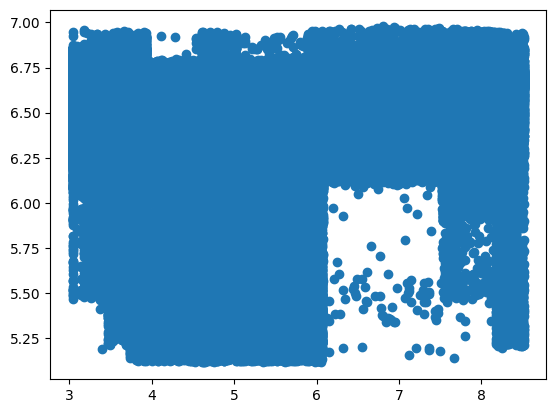

In [ ]:
plt.scatter(train[label], train_preds)

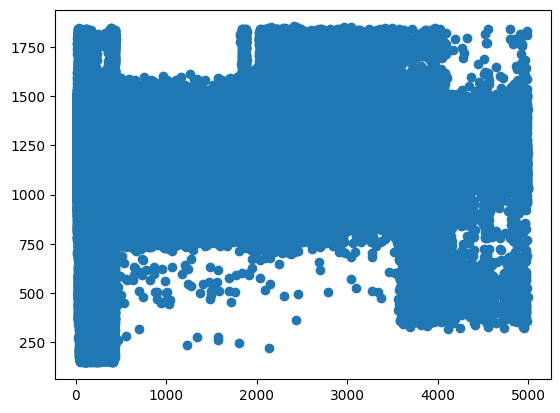

In [ ]:
plt.scatter(train[label], train_preds)